In [1]:
import pandas as pd
import  sys
sys.path.append("//Users//davislab//Downloads//RSAlgorithms-master")
import numpy as np
from prettyprinter import cpprint
from metric import Metric
from configx.configx import ConfigX
from utility.tools import denormalize,sigmoid,normalize
# from model.mf import MF
# from model.social_rec import SocialRec

In [2]:
import sys
sys.path.append("//Users//davislab//Downloads//RSAlgorithms-master")
import os
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
# from configx.configx import ConfigX
def split_5_folds(configx):
    K = configx.k_fold_num
    names = ['user_id', 'item_id', 'rating']
    df = pd.read_csv("//Users//davislab//Downloads//RSAlgorithms-master//data/Lthing_rating1.txt", sep=configx.sep, names=names)
    ratings = coo_matrix((df.rating, (df.user_id, df.item_id)))
    users = np.unique(ratings.row)
    ratings = ratings.tocsr()

    rows = list()
    cols = list()
    vals = list()
    nonzeros = list()

    for k in range(K):
        size_of_bucket = int(ratings.nnz / K)
        if k == K - 1:
            size_of_bucket += ratings.nnz % K
        rows.append(np.zeros(size_of_bucket))
        cols.append(np.zeros(size_of_bucket))
        vals.append(np.zeros(size_of_bucket))
        nonzeros.append(0)

    for i, user in enumerate(users):
        items = ratings[user, :].indices
        rating_vals = ratings[user, :].data
        index_list = [i for i in range(K)] * int(len(items) / float(K) + 1)
        np.random.shuffle(index_list)
        index_list = np.array(index_list)

        for k in range(K):
            k_index_list = (index_list[:len(items)] == k)
            from_ind = nonzeros[k]
            to_ind = nonzeros[k] + sum(k_index_list)

            if to_ind >= len(rows[k]):
                rows[k] = np.append(rows[k], np.zeros(size_of_bucket))
                cols[k] = np.append(cols[k], np.zeros(size_of_bucket))
                vals[k] = np.append(vals[k], np.zeros(size_of_bucket))
                k_index_list = (index_list[:len(items)] == k)

            rows[k][from_ind:to_ind] = [user] * sum(k_index_list)
            cols[k][from_ind:to_ind] = items[k_index_list]
            vals[k][from_ind:to_ind] = rating_vals[k_index_list]
            nonzeros[k] += sum(k_index_list)


    for k, (row, col, val, nonzero) in enumerate(zip(rows, cols, vals, nonzeros)):
        bucket_df = pd.DataFrame({'user': row[:nonzero], 'item': col[:nonzero], 'rating': val[:nonzero]},
                                 columns=['user', 'item', 'rating'])
        bucket_df.to_csv("/Users/davislab/Downloads/RSAlgorithms-master/data/cv/%s-%d.csv" % (configx.dataset_name, k), sep=configx.sep, header=False, index=False)
        print("%s -fold%d data generated finished!" % (configx.dataset_name, k))

    print("All Data Generated Done!")

In [3]:
configx = ConfigX()
split_5_folds(configx)

ep -fold0 data generated finished!
ep -fold1 data generated finished!
ep -fold2 data generated finished!
ep -fold3 data generated finished!
ep -fold4 data generated finished!
All Data Generated Done!


In [4]:
configx.__dict__

{'dataset_name': 'ep',
 'k_fold_num': 5,
 'rating_path': '//Users//davislab//Downloads//RSAlgorithms-master//data//Lthing_rating1.txt',
 'rating_cv_path': '//Users//davislab//Downloads//RSAlgorithms-master//data//cv//',
 'trust_path': '//Users//davislab//Downloads//RSAlgorithms-master//data//Lthing_trust.txt',
 'sep': ' ',
 'random_state': 0,
 'size': 0.8,
 'min_val': 0.5,
 'max_val': 5,
 'coldUserRating': 5,
 'factor': 10,
 'threshold': 0.0001,
 'lr': 0.01,
 'maxIter': 5,
 'lambdaP': 0.001,
 'lambdaQ': 0.001,
 'gamma': 0,
 'isEarlyStopping': False,
 'result_path': '//Users//davislab//Downloads//RSAlgorithms-master/results/',
 'model_path': 'model/',
 'result_log_path': 'log/'}

In [5]:
import  sys

import numpy as np
import matplotlib.pylab as plt

from prettyprinter import cpprint
from metrics.metric import Metric
# from utility.tools import denormalize,sigmoid
# from reader.rating import RatingGetter
# from configx.configx import ConfigX

class MF(object):
    """
    docstring for MF
    the base class for matrix factorization based model-parent class
    """

    def __init__(self):
        super(MF, self).__init__()
        self.config = ConfigX()
        cpprint(self.config.__dict__)  #print the configuration

        # self.rg = RatingGetter()  # loading raing data
        # self.init_model()
        self.iter_rmse = []
        self.iter_mae = []
        pass

    def init_model(self,k):
        self.read_data(k)
        self.P = np.random.rand(self.rg.get_train_size()[0], self.config.factor) / (self.config.factor ** 0.5)  # latent user matrix
        self.Q = np.random.rand(self.rg.get_train_size()[1], self.config.factor) / (self.config.factor ** 0.5)  # latent item matrix
        self.loss, self.lastLoss = 0.0, 0.0
        self.lastRmse, self.lastMae = 10.0,10.0
        pass

    def read_data(self,k):
        self.rg = RatingGetter(k)
        pass

    def train_model(self,k):
        self.init_model(k)
        pass

    # test all users in test set
    def predict_model(self):
        res = []
        for ind, entry in enumerate(self.rg.testSet()):
            user, item, rating = entry
            rating_length = len(self.rg.trainSet_u[user]) # remove cold start users for test
            if rating_length <= self.config.coldUserRating:
                continue

            prediction = self.predict(user, item)
            # denormalize
            prediction = denormalize(prediction, self.config.min_val, self.config.max_val)

            pred = self.checkRatingBoundary(prediction)
            # add prediction in order to measure
            res.append([user, item, rating, pred])
        rmse = Metric.RMSE(res)
        mae = Metric.MAE(res)
        self.iter_rmse.append(rmse)  # for plot
        self.iter_mae.append(mae)
        return rmse, mae

    # test cold start users among test set
    def predict_model_cold_users(self):
        res = []
        for user in self.rg.testColdUserSet_u.keys():
            for item in self.rg.testColdUserSet_u[user].keys():
                rating = self.rg.testColdUserSet_u[user][item]
                pred = self.predict(user, item)
                # pred = sigmoid(pred)
                # denormalize
                pred = denormalize(pred, self.config.min_val, self.config.max_val)
                pred = self.checkRatingBoundary(pred)
                res.append([user, item, rating, pred])
        rmse = Metric.RMSE(res)
        mae = Metric.MAE(res)
        return rmse,mae

    def predict(self, u, i):
        if self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.P[self.rg.user[u]].dot(self.Q[self.rg.item[i]])
        elif self.rg.containsUser(u) and not self.rg.containsItem(i):
            return self.rg.userMeans[u]
        elif not self.rg.containsUser(u) and self.rg.containsItem(i):
            return self.rg.itemMeans[i]
        else:
            return self.rg.globalMean

    def checkRatingBoundary(self, prediction):
        prediction =round( min( max( prediction , self.config.min_val ) , self.config.max_val ) ,3)
        return prediction

    def isConverged(self, iter):
        loss=[]
        from math import isnan
        if isnan(self.loss):
            print(
                'Loss = NaN or Infinity: current settings does not fit the recommender! Change the settings and try again!')
            exit(-1)

        deltaLoss = (self.lastLoss - self.loss)
        rmse, mae = self.predict_model()

        # early stopping
        if self.config.isEarlyStopping == True:
            cond = self.lastRmse < rmse
            if cond:
                print('test rmse increase, so early stopping')
                return cond
            self.lastRmse = rmse
            self.lastMae = mae
            
        loss.append(self.loss)
        print('%s iteration %d: loss = %.4f, delta_loss = %.5f learning_Rate = %.5f rmse=%.5f mae=%.5f' % \
              (self.__class__, iter, self.loss, deltaLoss, self.config.lr, rmse, mae))

        # check if converged
        cond = abs(deltaLoss) < self.config.threshold
        converged = cond
        # if not converged:
        # self.updateLearningRate(iter)
        self.lastLoss = self.loss
        # shuffle(self.dao.trainingData)
        return converged

    def updateLearningRate(self, iter):
        if iter > 1:
            if abs(self.lastLoss) > abs(self.loss):
                self.config.lr *= 1.05
            else:
                self.config.lr *= 0.5
        if self.config.lr > 1:
            self.config.lr = 1

In [6]:
from collections import defaultdict

class TrustGetter(object):
    """
    docstring for TrustGetter
    read trust data and save the global parameters

    """

    def __init__(self):
        super(TrustGetter, self).__init__()
        self.config = ConfigX()
        self.user = {}  # used to store the order of users
        self.relations = self.get_relations()
        self.followees = defaultdict(dict)
        self.followers = {}
        self.matrix_User = {}
        self.matrix_Item = {}
        self.generate_data_set()

    def generate_data_set(self):
        triple = []
        for line in self.relations:
            userId1, userId2, weight = line
            # add relations to dict
            if not userId1 in self.followees:
                self.followees[userId1] = {}
            self.followees[userId1][userId2] = weight
            if not userId2 in self.followers:
                self.followers[userId2] = {}
            self.followers[userId2][userId1] = weight
            # order the user
            if not userId1 in self.user:
                userid1 = self.user[userId1] = len(self.user)
            if not userId2 in self.user:
                userid2 = self.user[userId2] = len(self.user)
            if not userid1 in self.matrix_User:
                self.matrix_User[userid1] = {}
            if not userid2 in self.matrix_User:
                self.matrix_Item[userid2] = {}
            self.matrix_User[userid1][userid2] = weight
            self.matrix_Item[userid2][userid1] = weight

    def get_relations(self):
        with open("//Users//davislab//Downloads//RSAlgorithms-master//data//Lthing_trust.txt", 'r') as f:
            for index, line in enumerate(f):
                u_from, u_to, t = line.strip('\r\n').split(self.config.sep)
                yield (int(u_from), int(u_to), float(t))

    def get_followees(self, u):
        if u in self.followees:
            return self.followees[u]
        else:
            return {}

    def get_followers(self, u):
        if u in self.followers:
            return self.followers[u]
        else:
            return {}

    def weight(self, u, k):
        if u in self.followees and k in self.followees[u]:
            return self.followees[u][k]
        else:
            return 0

In [11]:
from collections import defaultdict
import numpy as np

# from utility.tools import normalize
# from configx.configx import ConfigX
class RatingGetter(object):
    """
    docstring for RatingGetter
    read rating data and save the global parameters
    """

    def __init__(self, k):
        super(RatingGetter, self).__init__()
        self.config = ConfigX()
        self.k_current = k
        self.user = {}
        self.item = {}
        self.all_User = {}
        self.all_Item = {}
        self.id2user = {}
        self.id2item = {}
        self.dataSet_u = defaultdict(dict)
        self.trainSet_u = defaultdict(dict)
        self.trainSet_i = defaultdict(dict)
        self.testSet_u = defaultdict(dict)  # used to store the test set by hierarchy user:[item,rating]
        self.testSet_i = defaultdict(dict)  # used to store the test set by hierarchy item:[user,rating]
        self.testColdUserSet_u = defaultdict(dict)  # cold start users in test set
        self.trainHotUserSet = []  # hot users in train set
        self.trainSetLength = 0
        self.testSetLength = 0

        self.userMeans = {}  # used to store the mean values of users's ratings
        self.itemMeans = {}  # used to store the mean values of items's ratings
        self.globalMean = 0

        self.generate_data_set()  # generate train and test set
        self.getDataSet()
        self.get_data_statistics()
        self.get_cold_start_users()

    def generate_data_set(self):
        for index, line in enumerate(self.trainSet()):
            u, i, r = line
            # print(u,i,r)
            if not u in self.user:
                self.user[u] = len(self.user)
                self.id2user[self.user[u]] = u
            if not i in self.item:
                self.item[i] = len(self.item)
                self.id2item[self.item[i]] = i

            self.trainSet_u[u][i] = r
            self.trainSet_i[i][u] = r
            self.trainSetLength = index + 1
        self.all_User.update(self.user)
        self.all_Item.update(self.item)

        for index, line in enumerate(self.testSet()):
            u, i, r = line
            if not u in self.user:
                self.all_User[u] = len(self.all_User)
            if not i in self.item:
                self.all_Item[i] = len(self.all_Item)
            self.testSet_u[u][i] = r
            self.testSet_i[i][u] = r
            self.testSetLength = index + 1
        # print(self.trainSetLength)
        # print(self.testSetLength)
        pass

    # for cross validation
    def trainSet(self):
        k = self.k_current
        for i in range(self.config.k_fold_num):
            if i != k:
                data_path = "/Users/davislab/Downloads/RSAlgorithms-master/data/cv/" + self.config.dataset_name + "-" + str(i) + ".csv"
                print("train_path",data_path)
                # if not os.path.exists
                if not os.path.isfile(data_path):
                    print("the format of ratings data is wrong!")
                    sys.exit()
                with open(data_path, 'r') as f:
                    for index, line in enumerate(f):
                        u, i, r = line.strip('\r\n').split(self.config.sep)
                        r = normalize(float(r))  # scale the rating score to [0-1]
                        yield (int(float(u)), int(float(i)), float(r))

    def testSet(self):
#         k = self.k_current   #comment when testing on test data
#         data_path = "/Users/davislab/Downloads/RSAlgorithms-master/data/cv/" + self.config.dataset_name + "-" + str(k) + ".csv" #comment when testing on test data
        data_path = "/Users/davislab/Downloads/RSAlgorithms-master/data/Lthing_rating_test.txt" #uncomment when testing on test data
        print("test_path",data_path)  
        if not os.path.isfile(data_path):
            print("the format of ratings data is wrong!")
            sys.exit()
        with open(data_path, 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                yield (int(float(u)), int(float(i)), float(r))


    def getDataSet(self):
        with open("//Users//davislab//Downloads//RSAlgorithms-master//data//Lthing_rating1.txt", 'r') as f:
            for index, line in enumerate(f):
                u, i, r = line.strip('\r\n').split(self.config.sep)
                self.dataSet_u[int(u)][int(i)] = float(r)

    def get_train_size(self):
        return (len(self.user), len(self.item))

    # get cold start users in test set
    def get_cold_start_users(self):
        for user in self.testSet_u.keys():
            rating_length = len(self.trainSet_u[user])
            if rating_length <= self.config.coldUserRating:
                self.testColdUserSet_u[user] = self.testSet_u[user]
        # print('cold start users count', len(self.testColdUserSet_u))

    def get_data_statistics(self):

        total_rating = 0.0
        total_length = 0
        for u in self.user:
            u_total = sum(self.trainSet_u[u].values())
            u_length = len(self.trainSet_u[u])
            total_rating += u_total
            total_length += u_length
            self.userMeans[u] = u_total / float(u_length)

        for i in self.item:
            self.itemMeans[i] = sum(self.trainSet_i[i].values()) / float(len(self.trainSet_i[i]))

        if total_length == 0:
            self.globalMean = 0
        else:
            self.globalMean = total_rating / total_length

    def containsUser(self, u):
        'whether user is in training set'
        if u in self.user:
            return True
        else:
            return False

    def containsItem(self, i):
        'whether item is in training set'
        if i in self.item:
            return True
        else:
            return False

    def containsUserItem(self, user, item):
        if user in self.trainSet_u:
            if item in self.trainSet_u[user]:
                # print(user)
                # print(item)
                # print(self.trainSet_u[user][item])
                return True
        return False

    def get_row(self, u):
        return self.trainSet_u[u]

    def get_col(self, c):
        return self.trainSet_i[c]

    def user_rated_items(self, u):
        return self.trainSet_u[u].keys()

In [12]:
class SocialRec(MF):
    """
    docstring for SocialRec
    Ma H, Yang H, Lyu M R, et al. Sorec: social recommendation using probabilistic matrix factorization[C]//Proceedings of the 17th ACM conference on Information and knowledge management. ACM, 2008: 931-940.
    """

    def __init__(self):
        super(SocialRec, self).__init__()
        # self.config.lr=0.0001
        self.config.alpha = 0.1
        self.config.lambdaZ = 0.01
        self.tg = TrustGetter()
        # self.init_model()

    def init_model(self, k):
        super(SocialRec, self).init_model(k)
        self.Z = np.random.rand(self.rg.get_train_size()[0], self.config.factor) / (
                self.config.factor ** 0.5)  # latent user social matrix

    def train_model(self, k):
        super(SocialRec, self).train_model(k)
        iteration = 0
        while iteration < self.config.maxIter:
            # tempP=np.zeros((self.rg.get_train_size()[0], self.config.factor))
            self.loss = 0
            for index, line in enumerate(self.rg.trainSet()):
                user, item, rating = line
                u = self.rg.user[user]
                i = self.rg.item[item]
                error = rating - self.predict(user, item)
                self.loss += error ** 2
                p, q = self.P[u], self.Q[i]

                followees = self.tg.get_followees(user)
                zs = np.zeros(self.config.factor)
                for followee in followees:
                    if self.rg.containsUser(user) and self.rg.containsUser(followee):
                        vminus = len(self.tg.get_followers(followee))  # ~ d - (k)
                        uplus = len(self.tg.get_followees(user))  # ~ d + (i)
                        import math
                        try:
                            weight = math.sqrt(vminus / (uplus + vminus + 0.0))
                        except ZeroDivisionError:
                            weight = 1
                        zid = self.rg.user[followee]
                        z = self.Z[zid]
                        err = weight - z.dot(p)
                        self.loss += err ** 2
                        zs += -1.0 * err * p
                        self.Z[zid] += self.config.lr * (self.config.alpha * err * p - self.config.lambdaZ * z)

                self.P[u] += self.config.lr * (error * q - self.config.alpha * zs - self.config.lambdaP * p)
                self.Q[i] += self.config.lr * (error * p - self.config.lambdaQ * q)

            self.loss += self.config.lambdaP * (self.P * self.P).sum() + self.config.lambdaQ * (self.Q * self.Q).sum() \
                         + self.config.lambdaZ * (self.Z * self.Z).sum()

            iteration += 1
            if self.isConverged(iteration):
                break

In [10]:
if __name__ == '__main__':
    rmses_cv = []
    maes_cv = []
    tcsr = SocialRec()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses_cv.append(rmse)
        maes_cv.append(mae)
    rmse_avg_cv = sum(rmses_cv) / 5
    mae_avg_cv = sum(maes_cv) / 5
    print("the rmses for cv are %s" % rmses_cv)
    print("the maes for cv are %s" % maes_cv)
    print("the average of rmses for cv is %s " % rmse_avg_cv)
    print("the average of maes for cv is %s " % mae_avg_cv)

{
    'dataset_name': 'ep',
    'k_fold_num': 5,
    'rating_path':
        '//Users//davislab//Downloads//RSAlgorithms-master//data//'
        'Lthing_rating1.txt',
    'rating_cv_path': '//Users//davislab//Downloads//RSAlgorithms-master//data//cv//',
    'trust_path':
        '//Users//davislab//Downloads//RSAlgorithms-master//data//'
        'Lthing_trust.txt',
    'sep': ' ',
    'random_state': 0,
    'size': 0.8,
    'min_val': 0.5,
    'max_val': 5,
    'coldUserRating': 5,
    'factor': 10,
    'threshold': 0.0001,
    'lr': 0.01,
    'maxIter': 5,
    'lambdaP': 0.001,
    'lambdaQ': 0.001,
    'gamma': 0,
    'isEarlyStopping': False,
    'result_path': '//Users//davislab//Downloads//RSAlgorithms-master/results/',
    'model_path': 'model/',
    'result_log_path': 'log/'
}
the 0th cross validation training
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-1.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-2.csv
train_path /Users/davisl

train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-1.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-3.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-4.csv
test_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-2.csv
<class '__main__.SocialRec'> iteration 3: loss = 257298.4049, delta_loss = 52502.37438 learning_Rate = 0.01000 rmse=1.40810 mae=1.12858
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-0.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-1.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-3.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-4.csv
test_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-2.csv
<class '__main__.SocialRec'> iteration 4: loss = 227905.6229, delta_loss = 29392.78199 learning_Rate = 0.01000 rmse=1.35345 mae=1.07560
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv

In [14]:
#calling again for making prediction on unseen test set
if __name__ == '__main__':
    rmses_test = []
    maes_test = []
    tcsr = SocialRec()
    # print(bmf.rg.trainSet_u[1])
    for i in range(tcsr.config.k_fold_num):
        print('the %dth cross validation training' % i)
        tcsr.train_model(i)
        rmse, mae = tcsr.predict_model()
        rmses_test.append(rmse)
        maes_test.append(mae)
    rmse_avg_test = sum(rmses_test) / 5
    mae_avg_test = sum(maes_test) / 5
    print("the rmses for test are %s" % rmses_test)
    print("the maes for test are %s" % maes_test)
    print("the average of rmses for test is %s " % rmse_avg_test)
    print("the average of maes for test is %s " % mae_avg_test)

{
    'dataset_name': 'ep',
    'k_fold_num': 5,
    'rating_path':
        '//Users//davislab//Downloads//RSAlgorithms-master//data//'
        'Lthing_rating1.txt',
    'rating_cv_path': '//Users//davislab//Downloads//RSAlgorithms-master//data//cv//',
    'trust_path':
        '//Users//davislab//Downloads//RSAlgorithms-master//data//'
        'Lthing_trust.txt',
    'sep': ' ',
    'random_state': 0,
    'size': 0.8,
    'min_val': 0.5,
    'max_val': 5,
    'coldUserRating': 5,
    'factor': 10,
    'threshold': 0.0001,
    'lr': 0.01,
    'maxIter': 5,
    'lambdaP': 0.001,
    'lambdaQ': 0.001,
    'gamma': 0,
    'isEarlyStopping': False,
    'result_path': '//Users//davislab//Downloads//RSAlgorithms-master/results/',
    'model_path': 'model/',
    'result_log_path': 'log/'
}
the 0th cross validation training
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-1.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-2.csv
train_path /Users/davisl

<class '__main__.SocialRec'> iteration 2: loss = 310431.3461, delta_loss = 145142.28709 learning_Rate = 0.01000 rmse=1.49027 mae=1.20810
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-0.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-1.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-3.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-4.csv
test_path /Users/davislab/Downloads/RSAlgorithms-master/data/Lthing_rating_test.txt
<class '__main__.SocialRec'> iteration 3: loss = 257442.7132, delta_loss = 52988.63292 learning_Rate = 0.01000 rmse=1.40880 mae=1.12865
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-0.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-1.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-3.csv
train_path /Users/davislab/Downloads/RSAlgorithms-master/data/cv/ep-4.csv
test_path /Users/davislab/Downloads/RSAlgorithms-ma

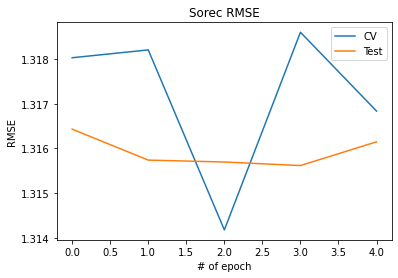

In [15]:
plt.plot(rmses_cv, label='CV')
plt.plot(rmses_test, label='Test')
plt.xlabel('# of epoch')
plt.ylabel('RMSE')
plt.title("Sorec RMSE")
plt.legend()
plt.show()